In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models import densenet169
from simple_cnn import SimpleCNN
from enhanced_cnn import EnhancedCNN

In [2]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    preprocessed_image = preprocess(image)
    return preprocessed_image

In [26]:
def plot_heatmap(image, prediction, cmap='hot', alpha=0.7):
    image = image.numpy().transpose((1, 2, 0))
    prediction = prediction.numpy()

    resized_prediction = cv2.resize(prediction, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

    normalized_prediction = (resized_prediction - np.min(resized_prediction)) / (np.max(resized_prediction) - np.min(resized_prediction))

    mask = np.zeros_like(normalized_prediction)
    center = (int(image.shape[1] / 2), int(image.shape[0] / 2))
    radius = int(min(image.shape[1], image.shape[0]) / 4)
    cv2.circle(mask, center, radius, 1, thickness=-1)
    masked_prediction = normalized_prediction * mask

    heatmap = cv2.GaussianBlur(masked_prediction, (0, 0), sigmaX=10, sigmaY=10)

    plt.imshow(image)
    plt.imshow(heatmap, cmap=cmap, alpha=alpha)
    plt.axis('off')
    plt.show()

tensor([386])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


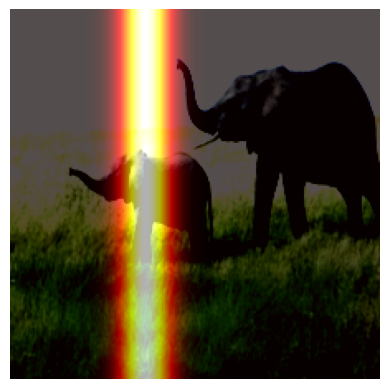

In [27]:
model = densenet169(pretrained=True)
model.eval()

image_path = r'DaneTest/elephant/xxx.png'

preprocessed_image = preprocess_image(image_path)
pred = model(preprocessed_image.unsqueeze(0)).argmax(dim=1)
print(pred)
with torch.no_grad():
    prediction = model(preprocessed_image.unsqueeze(0))

plot_heatmap(preprocessed_image, prediction)

tensor([101])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


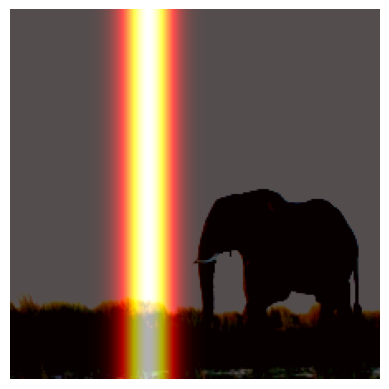

In [28]:
model = densenet169(pretrained=True)
model.eval()

image_path = r'DaneTest/elephant/xx1.png'

preprocessed_image = preprocess_image(image_path)
pred = model(preprocessed_image.unsqueeze(0)).argmax(dim=1)
print(pred)#class 101 - tusker/kły
with torch.no_grad():
    prediction = model(preprocessed_image.unsqueeze(0))

plot_heatmap(preprocessed_image, prediction)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([385])


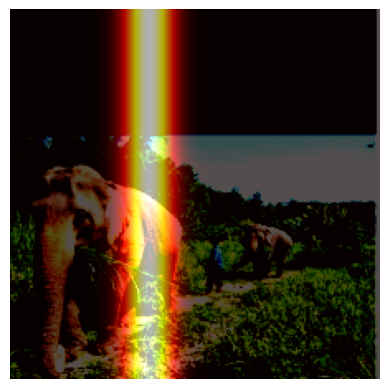

In [29]:
model = densenet169(pretrained=True)
model.eval()

image_path = r'DaneTest/elephant/xx2.png'

preprocessed_image = preprocess_image(image_path)
pred = model(preprocessed_image.unsqueeze(0)).argmax(dim=1)
print(pred)#class 385/Indian elephant, Elephas maximus
with torch.no_grad():
    prediction = model(preprocessed_image.unsqueeze(0))

plot_heatmap(preprocessed_image, prediction)

tensor([537])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


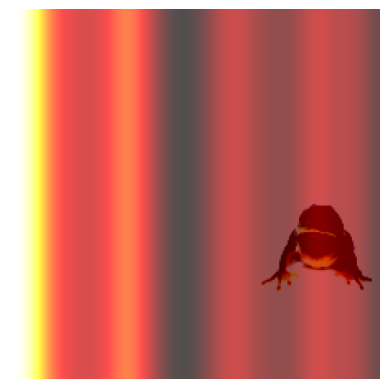

In [30]:
model = densenet169(pretrained=True)
model.eval()

image_path = r'DaneTest/frog/yyy.png'

preprocessed_image = preprocess_image(image_path)
pred = model(preprocessed_image.unsqueeze(0)).argmax(dim=1)
print(pred)#class 385/Indian elephant, Elephas maximus
with torch.no_grad():
    prediction = model(preprocessed_image.unsqueeze(0))

plot_heatmap(preprocessed_image, prediction)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([1])


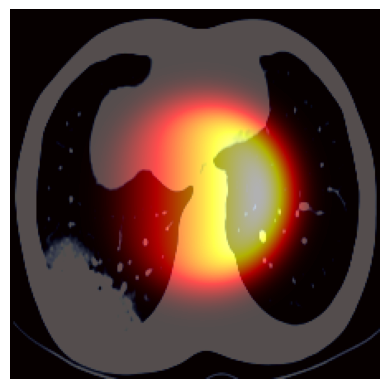

In [19]:
model = SimpleCNN()
model.load_state_dict(torch.load(r'TrainedModels/SimpleCNN.pt'))
model.eval()

image_path = r'CT_COVID_TEST/covid/2020.03.22.20040782-p25-1543.png'

preprocessed_image = preprocess_image(image_path)
pred = model(preprocessed_image.unsqueeze(0)).argmax(dim=1)
print(pred)
with torch.no_grad():
    prediction = model(preprocessed_image.unsqueeze(0))

plot_heatmap(preprocessed_image, prediction)

In [11]:
# Load the trained SimpleCNN model
model = SimpleCNN()
model.load_state_dict(torch.load('TrainedModels/SimpleCNN.pt'))
model.eval()

# Load and preprocess the image
image_path = 'CT_COVID_TEST/covid/2020.03.22.20040782-p25-1543.png'
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image = Image.open(image_path).convert('RGB')
preprocessed_image = preprocess(image).unsqueeze(0)

# Forward pass through the model
output = model(preprocessed_image)

# Compute the Grad-CAM heatmap
target_class = torch.argmax(output, dim=1)
output[:, target_class].backward(retain_graph=True)
grads = model.layer1[0].weight.grad

grad_cam = torch.mean(grads, dim=(2, 3), keepdim=True)
grad_cam = torch.relu_(grad_cam)  # Use relu_() for in-place ReLU activation

# Normalize the heatmap
grad_cam = torch.nn.functional.interpolate(grad_cam, size=(224, 224), mode='bilinear', align_corners=False)
grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

In [31]:
# Load the original image
image_path = r'CT_COVID_TEST/covid/2020.03.22.20040782-p25-1543.png'
image_np = cv2.imread(image_path)

# Convert the Grad-CAM heatmap to a NumPy array
heatmap = grad_cam.squeeze().detach().numpy()

# Normalize the heatmap values between 0 and 1
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Resize the heatmap to match the original image size
heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_LINEAR)

# Resize the heatmap to match the original image size
heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))

# Apply colormap to the heatmap
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
overlayed_image = cv2.addWeighted(image_np, 0.7, heatmap_colored, 0.3, 0)

# Plot the original image, heatmap, and overlayed image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(heatmap_colored)
ax[1].set_title("Heatmap")
ax[1].axis("off")
ax[2].imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
ax[2].set_title("Overlayed Image")
ax[2].axis("off")
plt.show()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:3699: error: (-215:Assertion failed) !dsize.empty() in function 'cv::hal::resize'
